<h1 align='center'><font color='orange'>Bike Sharing Demand Prediction</font></h1>
<h3 align='center'><font color='orange'><i>A Machine Learning approach to forecast Bike Rental Demand</i></font></h3>
<h2 align='center'><font color='orange'>Part 2 - Data Preparation</font></h2>

## <i>To try out the project, [click here...](https://bike-demand-prediction.herokuapp.com/)</i>

#### -> To check out Part 1 (Exploratory Data Analysis), [click here](https://nbviewer.jupyter.org/github/SarthakRana/Bike-Sharing-Demand-Prediction/blob/main/Bike_Sharing_EDA_Part1.ipynb)
#### -> To check out Part 3 (Modelling), [click here](https://nbviewer.jupyter.org/github/SarthakRana/Bike-Sharing-Demand-Prediction/blob/main/bike-demand-prediction-modelling-part3.ipynb)

<h1 align='center'><img src="https://knowledge.wharton.upenn.edu/wp-content/uploads/2017/09/092817_chinabikeshare.jpg"></h1>

# Quick Navigation
* [1. Introduction](#1)
* [2. Data Preparation : Cleaning + Preprocessing](#2)
    * [2.1 Missing data treatment](#3)
    * [2.2 Outlier Treatment](#4)
    * [2.3 Feature Engineering](#5)
        * [2.3.1 Variable Creation](#6)
        * [2.3.2 Feature Encoding (Variable Transformation)](#7)
    * [2.4 Removal of Highly correlated features](#8)
    * [2.5 Scaling the data](#9)
* [3. Save the preprocessed data in Directory](#10)

<a id='1'></a>
# 1. Introduction
Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

<a id='2'></a>
# 2. Data Preparation : Cleaning + Preprocessing

In this section, we are going to prepare data that is going to be used for training and testing purpose. We will break down this into following steps:
    
1. Missing values treatment.
2. Outlier treatment.
3. Feature Engineering
    * Suitable variable creation
    * Feature Encoding (variable transformation)    
4. Removal of Highly Correlated features.
5. Scaling the Data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set()

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

Let's first have a peek into what the train and test data looks like...

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df.sample(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
4153,2011-10-05 02:00:00,4,0,1,1,18.86,22.725,82,11.0014,1,2,3
5219,2011-12-11 13:00:00,4,0,0,1,12.30,16.665,31,0.0000,44,224,268
10138,2012-11-07 19:00:00,4,0,1,2,12.30,13.635,56,19.9995,17,302,319


In [4]:
datetime = list(train_df['datetime'])
month = [x.split(' ')[0].split('-')[1] for x in datetime]

In [5]:
month = [int(x) for x in month]

In [6]:
test_df.sample(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
5870,2012-10-27 10:00:00,4,0,0,1,22.14,25.76,73,19.0012
1760,2011-07-28 08:00:00,3,0,1,1,30.34,34.85,66,11.0014
3661,2012-02-26 08:00:00,1,0,0,1,8.20,9.85,51,16.9979


#### Before we start, I will drop `casual` and `registered` features as `count` is the only target feature we need to predict and focus on.

In [7]:
train_df.drop(['casual', 'registered'], inplace=True, axis=1)

<a id='3'></a>
## 2.1 Missing data treatment

In [8]:
# check for missing data
print("Missing data rows in Train Set = {}".format(pd.isnull(train_df).sum().sum()))
print("Missing data rows in Test Set = {}".format(pd.isnull(test_df).sum().sum()))

Missing data rows in Train Set = 0
Missing data rows in Test Set = 0


***There are no missing values in train and test set. Hence no treatment needed.***

<a id='4'></a>
## 2.2 Outlier Treatment

We will use the IQR method to eliminate any outliers.

In [9]:
print("Shape before outlier treatment :", train_df.shape)

Shape before outlier treatment : (10886, 10)


In [10]:
Q1 = train_df['count'].quantile(0.25)
Q3 = train_df['count'].quantile(0.75)
IQR = Q3-Q1
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

In [11]:
# Retain only those rows where 'count' value greater than lower bound and less than upper bound.
train_df = train_df[(train_df['count'] > lower_bound) & (train_df['count'] < upper_bound)]
print("Shape after outlier treatment :", train_df.shape)

Shape after outlier treatment : (10583, 10)


In [12]:
# Reset index
train_df = train_df.reset_index(drop=True)

<a id='5'></a>
## 2.3 Feature Engineering

We will be performing Feature Engineering as follows :-

<a id='6'></a>
### 2.3.1 Variable Creation

Here, we will extract the necessary info from `datetime` column. After that, we will drop it. 

<a id='7'></a>
### 2.3.2 Feature Encoding (Variable Transformation)
In our data, we can see that features like `hour`,`season`, `holiday`, `workingday` and `weather` are already encoded (i.e. already an integer data rather than categorical data). In this section, we will change  `season` and `weather` features to one hot encoded features. This is done to :
1. Nullify the affect of greater values in features i.e. all values should be treated equally.
2. Avoid the dummy variable trap.

In [13]:
class FeatureEngineering:
    """
    This is the preprocess Pipleline for train and test data.
    Preprocessing is divided in 2 phases:
    1. Variable Creation : Extract relevant info as new features from `datetime` column.
    2. Feature Encoding : Aim is to create a final dataframe having all required features encoded properly.
    """
    def extractInfoFromDatetime(data, dfType):
        
        # Get time of day (Hour) from datetime
        data['hour'] = data['datetime'].apply(lambda x : x.split(' ')[1])
        data['hour'] = data['hour'].apply(lambda x : x.split(':')[0])
        data['hour'] = data['hour'].apply(lambda x : int(x))
        
        # Get month from datetime
        data['month'] = data['datetime'].apply(lambda x : x.split(' ')[0]).apply(lambda y : y.split('-')[1])
        data['month'] = data['month'].apply(lambda x : int(x))
        
        # drop datetime feature
        del data['datetime']
                
        # Reorder columns
        if dfType == 'train':
            new_cols = ['hour', 'month', 'season', 'holiday', 'workingday', 'weather', 
                        'temp', 'atemp', 'humidity', 'windspeed', 'count']
        else:
            new_cols = ['hour', 'month', 'season', 'holiday', 'workingday', 
                        'weather', 'temp', 'atemp', 'humidity', 'windspeed']
            
        data = data[new_cols]
        return data
        
        
    def encodeFeature(feature, data):
        # one hot encode the passed feature
        feat = data[feature].values
        feat = feat.reshape(len(feat), 1)
        enc = OneHotEncoder(sparse=False)
        feat = enc.fit_transform(feat)
        feat_df = pd.DataFrame(feat)
        # save feature encoder
        filename = feature + "_ohe_encoder.pkl"
        with open(filename, "wb") as file:
            pickle.dump(enc, file)
        return feat_df
        
    
    def createEncodedFeaturesDataFrame(data):
        
        # Store feature info before starting preprocessing
        months = list(data['month'].unique())
        seasons = ['spring', 'summer', 'fall', 'winter']
        weathers = ['clear', 'mist', 'light_rain', 'heavy_rain']
        
        # Convert season and weather to one hot encoded values
        season_df = FeatureEngineering.encodeFeature('season', data)
        weather_df = FeatureEngineering.encodeFeature('weather', data)

        # Create column names for season dataframe
        season_new_cols= []
        for i in range(len(seasons)):
            season_new_cols.append("season_" + seasons[i])

        # Create column names for weather dataframe
        weather_new_cols= []
        for i in range(len(weathers)):
            weather_new_cols.append("weather_" + weathers[i])
   
        # Assign new column names to encoded dataframes
        season_df.columns = season_new_cols
        weather_df.columns = weather_new_cols
        
        # Now we need to drop one column from each newly created dataframe. This is done to avoid the Dummy Variable trap.
        # For convinience, we will drop the first column of each dataframe
        season_df = season_df.iloc[:, 1:]
        weather_df = weather_df.iloc[:, 1:]
        
        # Now, we will add these dataframes back to original dataframe
        frames = [data, season_df, weather_df]
        data = pd.concat(frames, axis=1)
        
        # drop `hour`, `month`, 'season' and 'weather' features
        del data['season']
        del data['weather']
        return data
    
    
    def process(data, dfType):
        df = FeatureEngineering.extractInfoFromDatetime(data, dfType)
        final_df = FeatureEngineering.createEncodedFeaturesDataFrame(df)
        return final_df

In [14]:
train_df_after_fe = FeatureEngineering.process(train_df, 'train')
test_df_after_fe = FeatureEngineering.process(test_df, 'test')

In [15]:
train_df_after_fe.head()

,hour,month,holiday,workingday,temp,atemp,humidity,windspeed,count,season_summer,season_fall,season_winter,weather_mist,weather_light_rain,weather_heavy_rain
0,0,1,0,0,9.84,14.395,81,0.0,16,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,0,0,9.02,13.635,80,0.0,40,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1,0,0,9.02,13.635,80,0.0,32,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1,0,0,9.84,14.395,75,0.0,13,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1,0,0,9.84,14.395,75,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0


<a id='8'></a>
## 2.4 Removal of Highly correlated features

We will make use of heatmap to visualize highly correlated features.

In [16]:
train_df_after_fe.columns

Index(['hour', 'month', 'holiday', 'workingday', 'temp', 'atemp', 'humidity',
       'windspeed', 'count', 'season_summer', 'season_fall', 'season_winter',
       'weather_mist', 'weather_light_rain', 'weather_heavy_rain'],
      dtype='object')

In [17]:
indep_features = ['hour', 'month', 'holiday', 'workingday', 'temp', 'atemp', 'humidity',
       'windspeed', 'season_summer', 'season_fall', 'season_winter',
       'weather_mist', 'weather_light_rain', 'weather_heavy_rain']
temp_train_df = train_df_after_fe[indep_features]

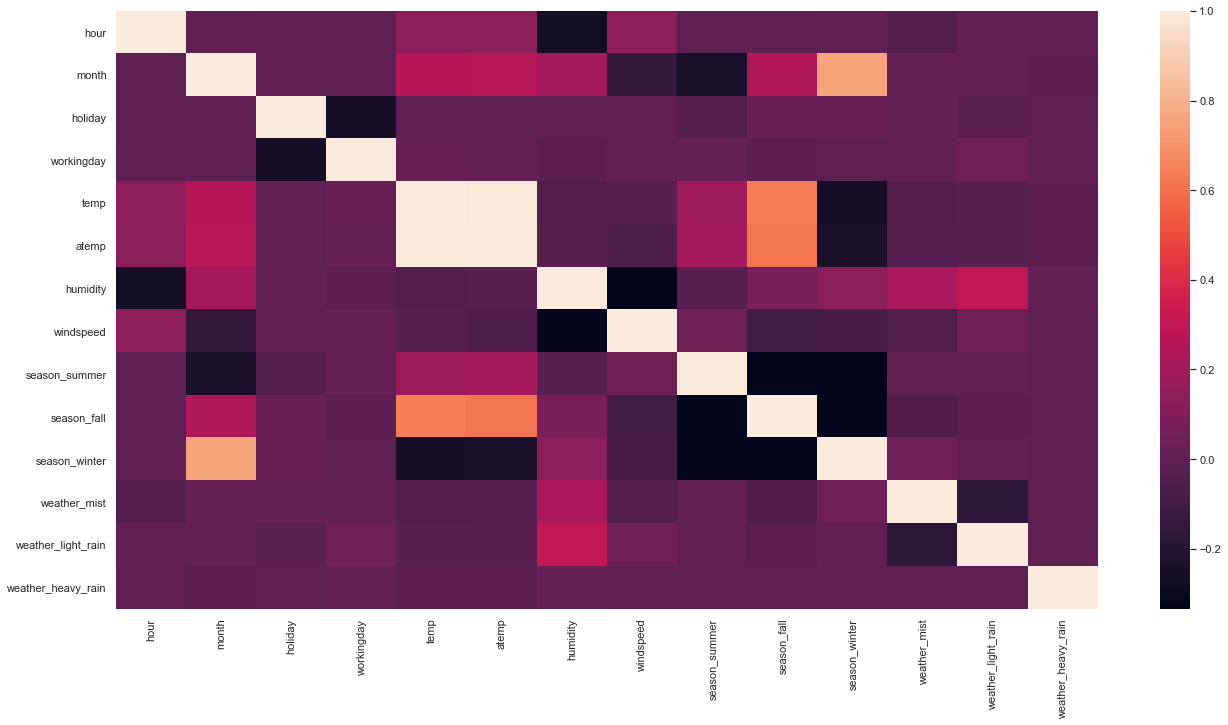

In [18]:
plt.figure(figsize=(22,11))
temp_corrmat = temp_train_df.corr()
sns.heatmap(temp_corrmat)
plt.show()

There is a high correlation between `temp` and `atemp`. So, let's get rid of `atemp`

In [19]:
del train_df_after_fe['atemp']
del test_df_after_fe['atemp']

In [20]:
train_df_after_fe.sample(5)

,hour,month,holiday,workingday,temp,humidity,windspeed,count,season_summer,season_fall,season_winter,weather_mist,weather_light_rain,weather_heavy_rain
3119,21,7,0,1,30.34,66,12.9980,202,0.0,1.0,0.0,0.0,0.0,0.0
7854,19,6,0,1,31.16,48,22.0028,596,1.0,0.0,0.0,1.0,0.0,0.0
5218,12,12,0,0,10.66,35,0.0000,288,0.0,0.0,1.0,0.0,0.0,0.0
4468,5,10,0,1,18.86,88,0.0000,21,0.0,0.0,1.0,1.0,0.0,0.0
9189,8,9,0,0,22.96,49,27.9993,212,0.0,1.0,0.0,0.0,0.0,0.0


In [21]:
train_df_after_fe['hour'] = train_df_after_fe['hour'].apply(lambda x : int(x))

<a id='9'></a>
## 2.5 Scaling the data

In [22]:
# Separate the target features
target_features = 'count'
target_df = train_df_after_fe[target_features]

# Drop the target features to for a dataframe containing the independent features
X_train = train_df_after_fe.drop(target_features, axis=1)

# retain the column labels
X_train_cols = X_train.columns

In [23]:
scaler = StandardScaler()
train_df_scaled = scaler.fit_transform(X_train)
test_df_scaled = scaler.transform(test_df_after_fe)

In [30]:
# Save data scaler
filename = 'scaler.pkl'
with open(filename, "wb") as f:
    pickle.dump(scaler, f)
    f.close()

<a id='10'></a>
# 3. Save the preprocessed data in Directory

In [26]:
X_train = pd.DataFrame(train_df_scaled, columns=X_train_cols)
X_test = pd.DataFrame(test_df_scaled, columns=X_train_cols)
train_processed = pd.concat([X_train, target_df], axis=1)
test_processed = X_test.copy()

In [27]:
train_processed.to_csv('train_processed.csv', index=False)
test_processed.to_csv('test_processed.csv', index=False)